# Load Library

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import warnings

warnings.filterwarnings('ignore')

In [ ]:
from tqdm import tqdm
import os
import data_utils
import model_utils
from attack_utils import get_CSMIA_case_by_case_results, CSMIA_attack, LOMIA_attack, imputation_attack, whitebox_neuron_attack, get_LOMIA_results
from data_utils import oneHotCatVars, filter_random_data_by_conf_score
from experiment_utils import MIAExperiment
from disparity_inference_utils import get_confidence_array, draw_confidence_array_scatter, get_indices_by_group_condition, get_corr_btn_sens_and_out_per_subgroup, get_slopes, get_angular_difference, calculate_stds, get_mutual_info_btn_sens_and_out_per_subgroup
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network._base import ACTIVATIONS
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import tabulate
import pickle
import copy
from scipy.stats import kendalltau, spearmanr

import matplotlib as mpl

# Load Dataset

In [28]:
experiments = { f"correlation_{i}":  MIAExperiment(sampling_condition_dict = 
    {
            'correlation': i
    }, shortname = f"correlation_{i}", random_state=0
) for i in np.arange(-0.9, 0.05, 0.05).round(2)[:]}

{(1, 1): 1249, (1, 0): 23750, (0, 1): 23751, (0, 0): 1250}
{(1, 1): 1875, (1, 0): 23125, (0, 1): 23125, (0, 0): 1875}
{(1, 1): 2499, (1, 0): 22500, (0, 1): 22501, (0, 0): 2500}
{(1, 1): 3125, (1, 0): 21875, (0, 1): 21875, (0, 0): 3125}
{(1, 1): 3750, (1, 0): 21250, (0, 1): 21250, (0, 0): 3750}
{(1, 1): 4375, (1, 0): 20625, (0, 1): 20625, (0, 0): 4375}
{(1, 1): 5000, (1, 0): 20000, (0, 1): 20000, (0, 0): 5000}
{(1, 1): 5624, (1, 0): 19375, (0, 1): 19376, (0, 0): 5625}
{(1, 1): 6250, (1, 0): 18750, (0, 1): 18750, (0, 0): 6250}
{(1, 1): 6875, (1, 0): 18125, (0, 1): 18125, (0, 0): 6875}
{(1, 1): 7500, (1, 0): 17500, (0, 1): 17500, (0, 0): 7500}
{(1, 1): 8125, (1, 0): 16875, (0, 1): 16875, (0, 0): 8125}
{(1, 1): 8750, (1, 0): 16250, (0, 1): 16250, (0, 0): 8750}
{(1, 1): 9375, (1, 0): 15625, (0, 1): 15625, (0, 0): 9375}
{(1, 1): 10000, (1, 0): 15000, (0, 1): 15000, (0, 0): 10000}
{(1, 1): 10625, (1, 0): 14374, (0, 1): 14375, (0, 0): 10626}
{(1, 1): 11250, (1, 0): 13750, (0, 1): 13750, (0, 0)

In [18]:
experiments_texas = { f"correlation_{i}":  MIAExperiment(sampling_condition_dict = 
    {
            'correlation': i,
    }, shortname = f"correlation_{i}", name='Texas100', sensitive_column='SEX_CODE', random_state=0
) for i in np.arange(0, 0.95, 0.05)[:]}

{(1, 1): 12500, (1, 0): 12500, (0, 1): 12500, (0, 0): 12500}
{(1, 1): 13125, (1, 0): 11875, (0, 1): 11875, (0, 0): 13125}
{(1, 1): 13750, (1, 0): 11250, (0, 1): 11250, (0, 0): 13750}
{(1, 1): 14374, (1, 0): 10625, (0, 1): 10626, (0, 0): 14375}
{(1, 1): 15000, (1, 0): 10000, (0, 1): 10000, (0, 0): 15000}
{(1, 1): 15625, (1, 0): 9375, (0, 1): 9375, (0, 0): 15625}
{(1, 1): 16250, (1, 0): 8750, (0, 1): 8750, (0, 0): 16250}
{(1, 1): 16875, (1, 0): 8124, (0, 1): 8125, (0, 0): 16876}
{(1, 1): 17500, (1, 0): 7500, (0, 1): 7500, (0, 0): 17500}
{(1, 1): 18125, (1, 0): 6875, (0, 1): 6875, (0, 0): 18125}
{(1, 1): 18750, (1, 0): 6250, (0, 1): 6250, (0, 0): 18750}
{(1, 1): 19375, (1, 0): 5624, (0, 1): 5625, (0, 0): 19376}
{(1, 1): 20000, (1, 0): 4999, (0, 1): 5000, (0, 0): 20001}
{(1, 1): 20625, (1, 0): 4375, (0, 1): 4375, (0, 0): 20625}
{(1, 1): 21250, (1, 0): 3749, (0, 1): 3750, (0, 0): 21251}
{(1, 1): 21875, (1, 0): 3125, (0, 1): 3125, (0, 0): 21875}
{(1, 1): 22500, (1, 0): 2499, (0, 1): 2500, (0

# Train/Load Model

In [29]:
save_model = True

for experiment_key in experiments:
    experiment = experiments[experiment_key]
    print(f"Training classifier for experiment: {experiment}")
    try:
        experiment.clf = model_utils.load_model(f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model.pkl')
        print(f"Loaded classifier for experiment from file: {experiment}")
    except:
        # clf = model_utils.get_model(max_iter=500, hidden_layer_sizes=(256, 256))
        experiment.clf = model_utils.get_model(max_iter=500)
        experiment.clf.fit(experiment.X_train, experiment.y_tr_onehot)

        if save_model:
            model_utils.save_model(experiment.clf, f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model.pkl')

Training classifier for experiment: Census19_correlation_-0.9_rs0
Loaded classifier for experiment from file: Census19_correlation_-0.9_rs0
Training classifier for experiment: Census19_correlation_-0.85_rs0
Loaded classifier for experiment from file: Census19_correlation_-0.85_rs0
Training classifier for experiment: Census19_correlation_-0.8_rs0
Loaded classifier for experiment from file: Census19_correlation_-0.8_rs0
Training classifier for experiment: Census19_correlation_-0.75_rs0
Loaded classifier for experiment from file: Census19_correlation_-0.75_rs0
Training classifier for experiment: Census19_correlation_-0.7_rs0
Loaded classifier for experiment from file: Census19_correlation_-0.7_rs0
Training classifier for experiment: Census19_correlation_-0.65_rs0
Loaded classifier for experiment from file: Census19_correlation_-0.65_rs0
Training classifier for experiment: Census19_correlation_-0.6_rs0
Loaded classifier for experiment from file: Census19_correlation_-0.6_rs0
Training class

In [19]:
save_model = True

for experiment_key in experiments_texas:
    experiment = experiments_texas[experiment_key]
    print(f"Training classifier for experiment: {experiment}")
    try:
        experiment.clf = model_utils.load_model(f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model.pkl')
        print(f"Loaded classifier for experiment from file: {experiment}")
    except:
        # clf = model_utils.get_model(max_iter=500, hidden_layer_sizes=(256, 256))
        experiment.clf = model_utils.get_model(max_iter=500)
        experiment.clf.fit(experiment.X_train, experiment.y_tr_onehot)

        if save_model:
            model_utils.save_model(experiment.clf, f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model.pkl')

Training classifier for experiment: Texas100_correlation_0.0_rs0
Training classifier for experiment: Texas100_correlation_0.05_rs0
Training classifier for experiment: Texas100_correlation_0.1_rs0
Training classifier for experiment: Texas100_correlation_0.15000000000000002_rs0
Training classifier for experiment: Texas100_correlation_0.2_rs0
Training classifier for experiment: Texas100_correlation_0.25_rs0
Training classifier for experiment: Texas100_correlation_0.30000000000000004_rs0
Training classifier for experiment: Texas100_correlation_0.35000000000000003_rs0
Training classifier for experiment: Texas100_correlation_0.4_rs0
Training classifier for experiment: Texas100_correlation_0.45_rs0
Training classifier for experiment: Texas100_correlation_0.5_rs0
Training classifier for experiment: Texas100_correlation_0.55_rs0
Training classifier for experiment: Texas100_correlation_0.6000000000000001_rs0
Training classifier for experiment: Texas100_correlation_0.65_rs0
Training classifier fo

# Launch Attribute Inference Attacks

In [ ]:
for experiment_key in experiments:
    experiment = experiments[experiment_key]
    experiment.sens_pred_CSMIA, case_indices = CSMIA_attack(experiment.clf, experiment.X_train, experiment.y_tr, experiment.ds.ds.meta)   
    experiment.sens_pred_LOMIA = LOMIA_attack(experiment, experiment.clf, experiment.X_train, experiment.y_tr, experiment.ds.ds.meta)
    aux_indices = experiment.X_test.sample(n=5000, random_state=0).index
    experiment.X_aux, experiment.y_aux = experiment.X_test.loc[aux_indices], experiment.y_te[aux_indices]
    experiment.sens_pred_imputation = imputation_attack(experiment, experiment.X_train, experiment.y_tr, experiment.X_aux, experiment.y_aux, experiment.ds.ds.meta)
    experiment.sens_pred_neurimp = whitebox_neuron_attack(experiment, experiment.clf, experiment.X_train, experiment.y_tr, experiment.X_aux, experiment.y_aux, experiment.ds.ds.meta)


In [52]:
for experiment_key in experiments_texas:
    experiment = experiments_texas[experiment_key]
    experiment.sens_pred_CSMIA, case_indices = CSMIA_attack(experiment.clf, experiment.X_train, experiment.y_tr, experiment.ds.ds.meta)   
    experiment.sens_pred_LOMIA = LOMIA_attack(experiment, experiment.clf, experiment.X_train, experiment.y_tr, experiment.ds.ds.meta)
    aux_indices = experiment.X_test.sample(n=5000, random_state=0).index
    experiment.X_aux, experiment.y_aux = experiment.X_test.loc[aux_indices], experiment.y_te[aux_indices]
    experiment.sens_pred_imputation = imputation_attack(experiment, experiment.X_train, experiment.y_tr, experiment.X_aux, experiment.y_aux, experiment.ds.ds.meta)
    experiment.sens_pred_neurimp = whitebox_neuron_attack(experiment, experiment.clf, experiment.X_train, experiment.y_tr, experiment.X_aux, experiment.y_aux, experiment.ds.ds.meta)


# Plot Results

In [ ]:
from experiment_utils import eval_func, metrics

In [41]:
performance_dict = {}
for experiment_key in experiments:
    experiment = experiments[experiment_key]
    correlation = get_corr_btn_sens_and_out_per_subgroup(experiment, experiment.X_train, experiment.y_tr, {})
    performance_dict[correlation] = {}
    indices = get_indices_by_group_condition(experiment.X_train, {})
    performance_dict[correlation]['CSMIA_results'] = {metric: 100 * eval_func[metric](experiment.sens_val_ground_truth[indices], experiment.sens_pred_CSMIA[indices]) for metric in metrics}
    performance_dict[correlation]['LOMIA_results'] = {metric: 100 * eval_func[metric](experiment.sens_val_ground_truth[indices], experiment.sens_pred_LOMIA[indices]) for metric in metrics}
    performance_dict[correlation]['imputation_results'] = {metric: 100 * eval_func[metric](experiment.sens_val_ground_truth[indices], experiment.sens_pred_imputation[indices]) for metric in metrics}
    performance_dict[correlation]['wb_neuron_results'] = {metric: 100 * eval_func[metric](experiment.sens_val_ground_truth[indices], experiment.sens_pred_neurimp[indices]) for metric in metrics}

In [53]:
performance_dict_texas = {}
for experiment_key in experiments_texas:
    experiment = experiments_texas[experiment_key]
    correlation = get_corr_btn_sens_and_out_per_subgroup(experiment, experiment.X_train, experiment.y_tr, {})
    performance_dict_texas[correlation] = {}
    indices = get_indices_by_group_condition(experiment.X_train, {})
    performance_dict_texas[correlation]['CSMIA_results'] = {metric: 100 * eval_func[metric](experiment.sens_val_ground_truth[indices], experiment.sens_pred_CSMIA[indices]) for metric in metrics}
    performance_dict_texas[correlation]['LOMIA_results'] = {metric: 100 * eval_func[metric](experiment.sens_val_ground_truth[indices], experiment.sens_pred_LOMIA[indices]) for metric in metrics}
    performance_dict_texas[correlation]['imputation_results'] = {metric: 100 * eval_func[metric](experiment.sens_val_ground_truth[indices], experiment.sens_pred_imputation[indices]) for metric in metrics}
    performance_dict_texas[correlation]['wb_neuron_results'] = {metric: 100 * eval_func[metric](experiment.sens_val_ground_truth[indices], experiment.sens_pred_neurimp[indices]) for metric in metrics}

In [ ]:
mpl.rcParams['font.family'] = 'Avenir'
mpl.rcParams['font.size'] = 15

def plot_result(performance_dict, metric='accuracy'):
    attacks = ['CSMIA', 'LOMIA', 'imputation', 'wb_neuron']
    attack_names = attacks[:2] + ['Imputation', 'NeuronIMP']
    metric_name_dict = {'accuracy': 'Attack Accuracy', 'f1': 'F1 Score'}
    performance_dict_metric = {corr: {f'{attack}_results': performance_dict[corr][f'{attack}_results'][metric] for attack in attacks} for corr in performance_dict}

    df = pd.DataFrame.from_dict(performance_dict_metric, orient='index')
    fig, ax = plt.subplots(figsize=(6, 4.5))
    line_styles = ['-', '--', '-.', ':']
    colors = ['#000000', '#4D4D4D', '#7F7F7F', '#BFBFBF']  # Different shades of black/gray
    markers = ['o', 's', '^', 'd']  # Circle, square, triangle up, diamond
    for i, attack in enumerate(attacks):
        plt.plot(df.index, df[f'{attack}_results'], label=attack_names[i], marker=markers[i], linestyle=line_styles[i], color=colors[i], markersize=5)

    x_ticks = np.arange(df.index.min(), df.index.max() + 0., 0.15).round(2).tolist()
    plt.xticks(x_ticks)
    plt.legend()
    plt.xlabel('Correlation')
    plt.ylabel(metric_name_dict[metric])
    plt.grid(True, linewidth=0.25)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()

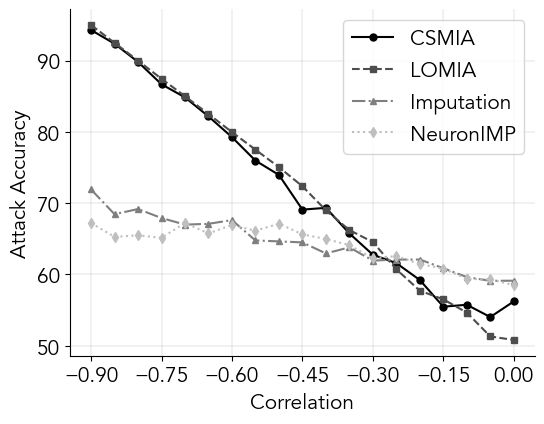

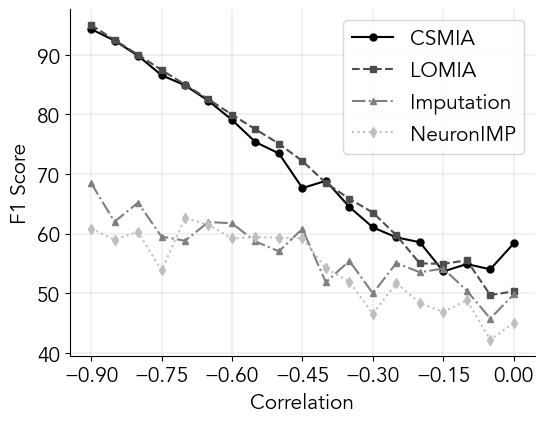

In [42]:
for metric in ['accuracy', 'f1']:
    plot_result(performance_dict, metric=metric)

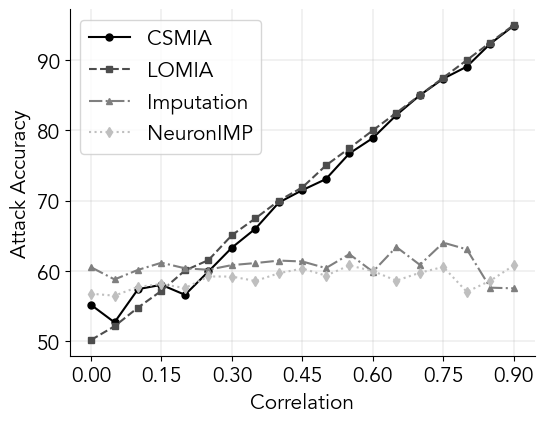

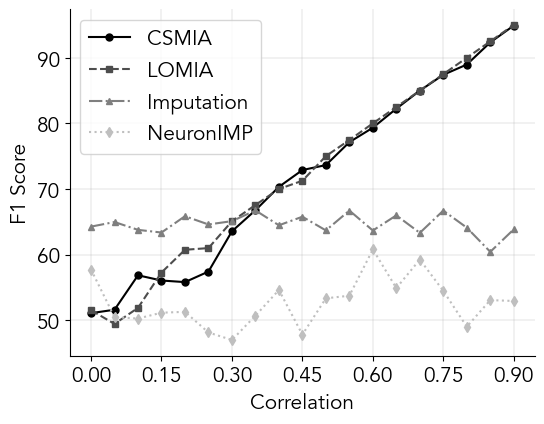

In [54]:
for metric in ['accuracy', 'f1']:
    plot_result(performance_dict_texas, metric=metric)